In [36]:
DATA_FPATH = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/full_Test_LIG_riboclette.h5'
FA_FPATH = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/reference/ensembl.cds.fa'
GC_FPATH = '../data/genetic_code.csv'

In [32]:
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import trange, tqdm
from Bio import SeqIO
import re
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

from tqdm.auto import trange

import PyComplexHeatmap as pch

In [3]:
df_trans_to_seq = []
with open(FA_FPATH, mode="r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        df_trans_to_seq.append([record.id, str(record.seq), record.description.split("gene_symbol:")[1].split()[0]])

df_trans_to_seq = pd.DataFrame(df_trans_to_seq, columns=["transcript", "sequence", "symbol"])
df_trans_to_seq.head()

,transcript,sequence,symbol
0,ENSMUST00000196221.1,ATGGCATAT,Trdd1
1,ENSMUST00000177564.1,ATCGGAGGGATACGAG,Trdd2
2,ENSMUST00000178537.1,GGGACAGGGGGC,Trbd1
3,ENSMUST00000178862.1,GGGACTGGGGGGGC,Trbd2
4,ENSMUST00000179520.1,CTAACTGGGAC,Ighd4-1


In [4]:
radius = 20
windows_attr = []
windows_counts = []
windows_seq = []
with h5py.File(DATA_FPATH, 'r') as f:
    transcripts = f['transcript'][:].astype('U') 
    conditions = f['condition'][:].astype('U') 
    ctrl_mask = np.nonzero(conditions == 'CTRL')[0]
    for transc_idx in tqdm(ctrl_mask):
        y_true = f['y_true_ctrl'][transc_idx]
        trasc_attr = f['attributions_ctrl'][transc_idx]
        transcript = transcripts[transc_idx]
        sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
        n_codons = int(np.sqrt(trasc_attr.shape[0]))
        trasc_attr = trasc_attr.reshape(n_codons, n_codons)
        topk_peaks = np.argsort(y_true)
        topk_peaks = topk_peaks[(topk_peaks >= radius) & (topk_peaks < n_codons - radius)]
        topk_peaks = topk_peaks[-10:]
        #windows.append(np.array([trasc_attr[i,i - radius :i + radius + 1] for i in range(radius, n_codons - radius)]))
        windows_attr.append(np.array([trasc_attr[i,i - radius :i + radius + 1] for i in topk_peaks]))
        windows_counts.append(np.array([y_true[i - radius :i + radius + 1] for i in topk_peaks]))
        windows_seq.append(np.array([sequence[i*3 - (radius)*3 :i*3 + (radius + 1)*3] for i in topk_peaks]))

windows_counts = np.concatenate(windows_counts)
windows_counts = windows_counts / np.nansum(windows_counts, 1)[:,None]

windows_attr = np.abs(np.concatenate(windows_attr))
windows_attr = windows_attr / np.sum(windows_attr, 1)[:,None]

windows_seq = np.concatenate(windows_seq)

  0%|          | 0/1057 [00:00<?, ?it/s]

In [347]:
peaks_data = [tuple(np.where(wa > .21)[0]) for wa in windows_attr]
peaks_to_cluster_id = {p: idx for idx, p in enumerate(set(peaks_data))}
clusters = np.array([peaks_to_cluster_id[p] for p in peaks_data])

In [349]:
from collections import defaultdict
cluster_codons = defaultdict(list)
for peaks, cluster_id in peaks_to_cluster_id.items():
    if len(peaks) == 0:
        continue
    for p in peaks:
        cluster_codons[cluster_id].append((np.sum(clusters == cluster_id), p-20, [seq[p*3:3*(p+1)] for seq in windows_seq[clusters == cluster_id]]))

In [280]:
cluster_codons

defaultdict(list,
            {0: [(1, -5, ['GAG']), (1, 1, ['AAG'])],
             1: [(23,
               -4,
               ['CCT',
                'AGG',
                'GAC',
                'GGG',
                'ACC',
                'CAG',
                'AGT',
                'GAC',
                'ATG',
                'CAG',
                'GCA',
                'GAC',
                'AGG',
                'AGT',
                'GGT',
                'GAC',
                'GCC',
                'GGG',
                'CAG',
                'GGG',
                'GAG',
                'GGT',
                'CAG']),
              (23,
               0,
               ['ATT',
                'GAG',
                'GAC',
                'GAC',
                'GAC',
                'GAC',
                'GAT',
                'CCT',
                'GTT',
                'TTT',
                'CAG',
                'GAC',
                'GGA',
                'GAC'

In [350]:
nunique = []
for k, v in cluster_codons.items():
    for n_seq, idx, pos in v:
        codons, codon_counts = np.unique(pos, return_counts=True)
        codon_counts = codon_counts / np.sum(codon_counts)
        nunique.append(
            pd.DataFrame(np.stack([codons, codon_counts]).T, columns=['codon', 'freq']).set_index('codon').reindex(genetic_code.index, fill_value=0).reset_index().assign(position=idx).assign(cluster=k).assign(n_samples=n_seq))


In [351]:
genetic_code = pd.read_csv(GC_FPATH, index_col=0).set_index('Codon')
genetic_code.head()

,AminoAcid
Codon,
AAA,Lys
AAC,Asn
AAG,Lys
AAT,Asn
ACA,Thr


In [352]:
data = pd.concat(nunique).assign(peak_id=lambda df: df.cluster.astype(str) + "_" + df.position.astype(str))#.set_index('peak_id')#.pivot(columns='Codon', values='freq').astype(float).fillna(0.)
data = data.astype(dict(freq='float', Codon='str', peak_id='str'))

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


Text(0.5, 0.98, 'Distribution of TOP5 attributions in the deprivation head, by condition')

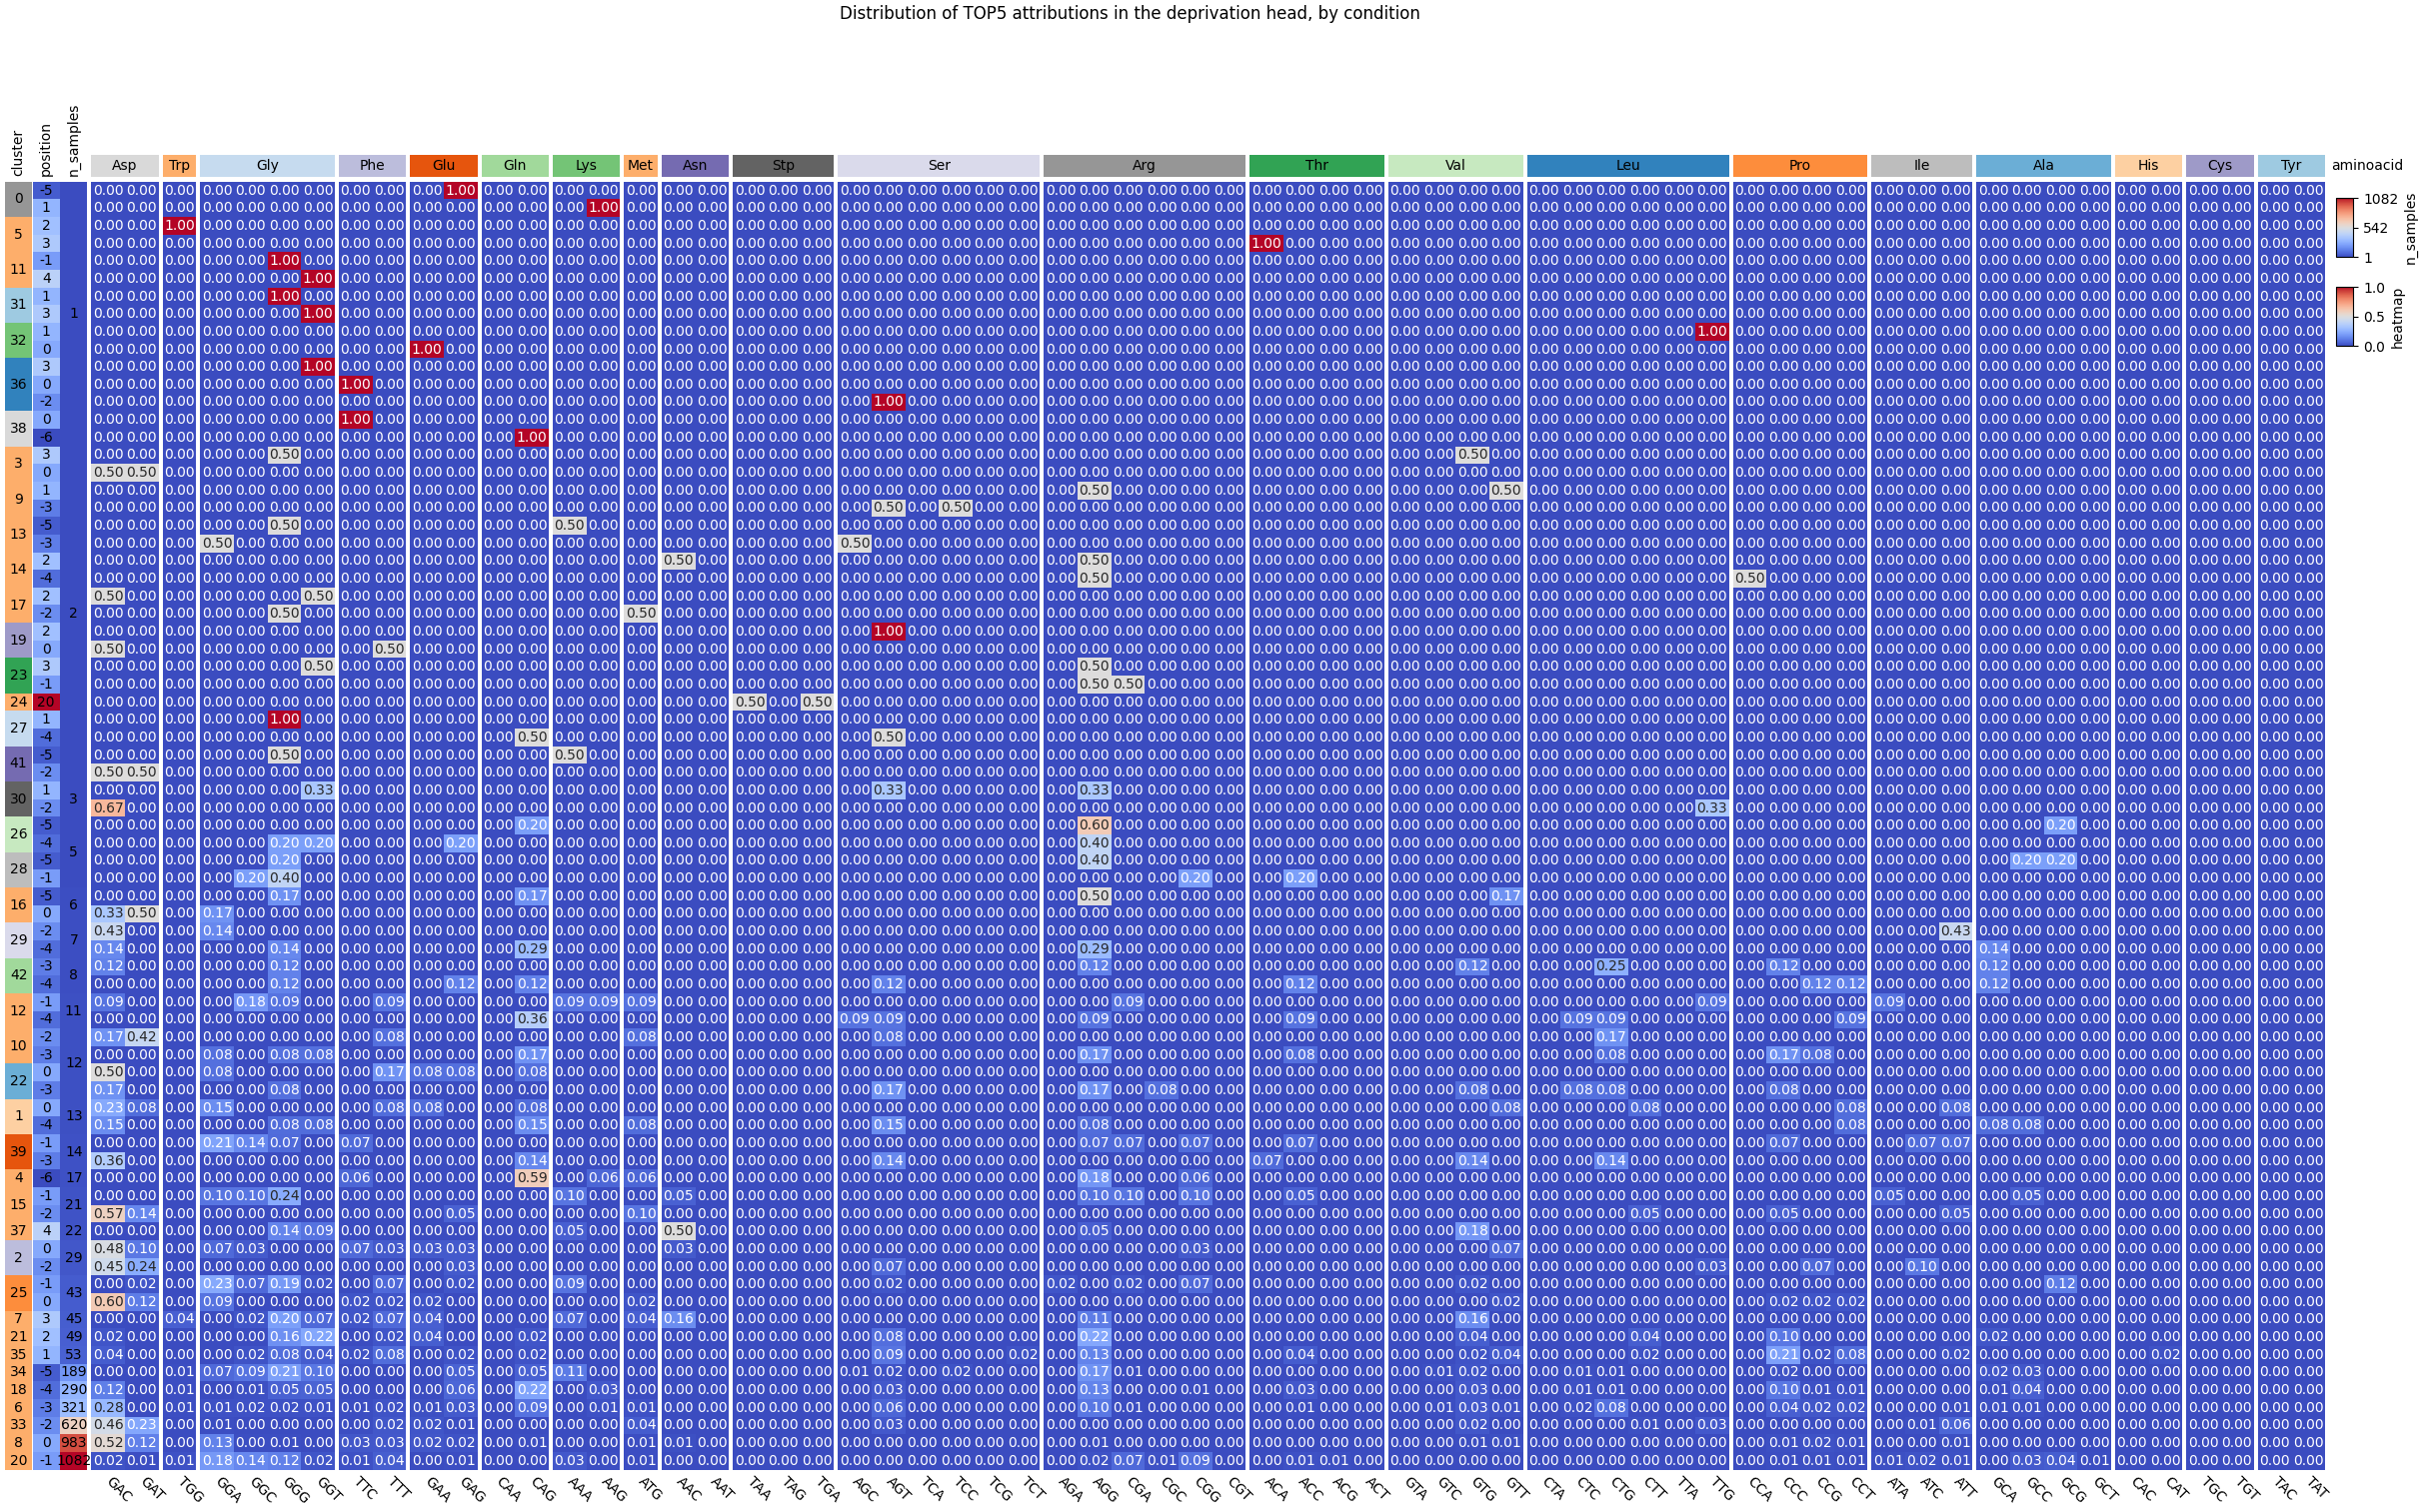

In [355]:
plt.figure(figsize=(30, n_clusters // 2))

cmap = plt.get_cmap('tab20c')
colors = np.array(cmap.colors)
np.random.seed(42)
np.random.shuffle(colors)
randomized_cmap = plt.matplotlib.colors.ListedColormap(colors)

col_ha = pch.HeatmapAnnotation(aminoacid=pch.anno_simple(genetic_code, add_text=True,legend=False,text_kws={'fontsize':10, 'color':'black'},cmap=randomized_cmap, height=5),axis=1)
row_ha = pch.HeatmapAnnotation(
    cluster=pch.anno_simple(data.groupby(['cluster', 'position'])[['cluster']].first(), add_text=True, legend=False,text_kws={'fontsize':10, 'color':'black','rotation':0}, height=7,cmap=randomized_cmap),
    position=pch.anno_simple(data.groupby(['cluster', 'position'])[['position']].first(), add_text=True, legend=False,text_kws={'fontsize':10, 'color':'black','rotation':0}, height=7, majority=False,cmap='coolwarm'),
    n_samples=pch.anno_simple(data.groupby(['cluster', 'position'])[['n_samples']].first(), add_text=True, legend=True, text_kws={'fontsize':10, 'color':'black','rotation':0}, height=10,cmap='coolwarm'),
    axis=0)
pch.ClusterMapPlotter(
    data=data.sort_values(['n_samples', 'cluster', 'position']).pivot_table(index=['cluster', 'position'],columns='Codon', values='freq', sort=False),
    col_split=genetic_code, col_split_gap=1,
    top_annotation=col_ha,
    left_annotation=row_ha,
    annot=True, 
    fmt='.2f',
    cmap='coolwarm',
    show_rownames=False,show_colnames=True,
    col_cluster=False,row_cluster=False,
    col_cluster_metric='euclidean',
    xticklabels_kws=dict(labelrotation=-45))
plt.suptitle('Distribution of TOP5 attributions in the deprivation head, by condition')
#plt.savefig('plots/top5_attr_depr_head.png', dpi=400, bbox_inches='tight')

/tmp/ipykernel_1525728/4119530920.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, (ax1, ax2) = plt.subplots(1,2)


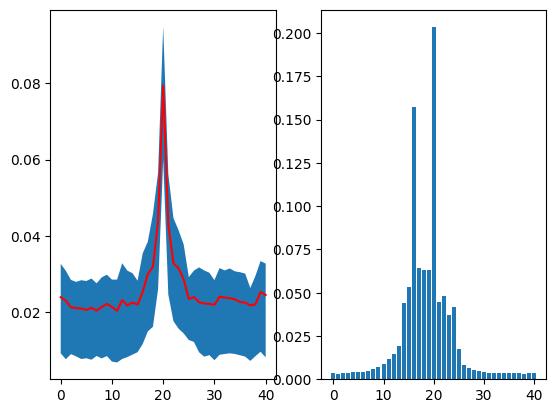

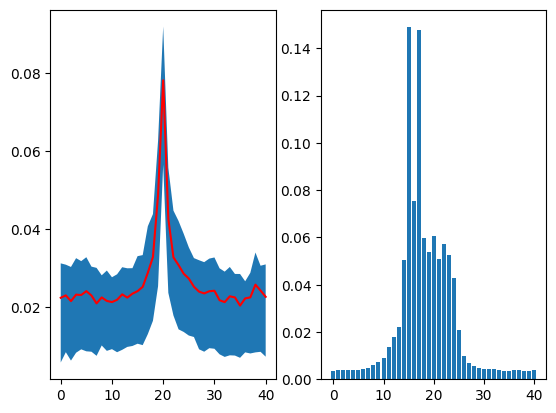

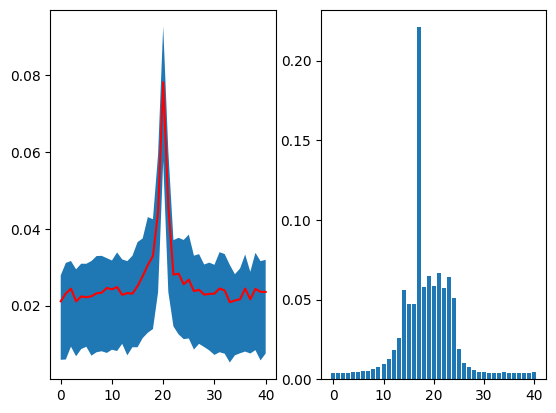

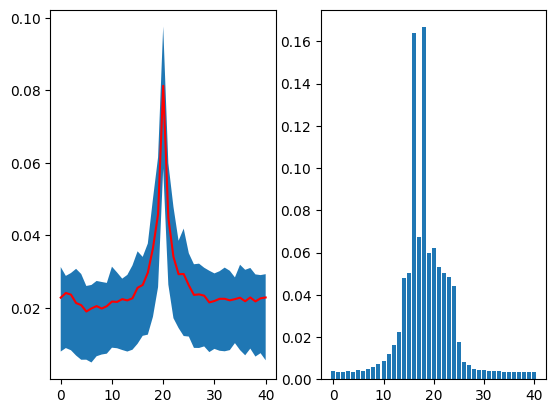

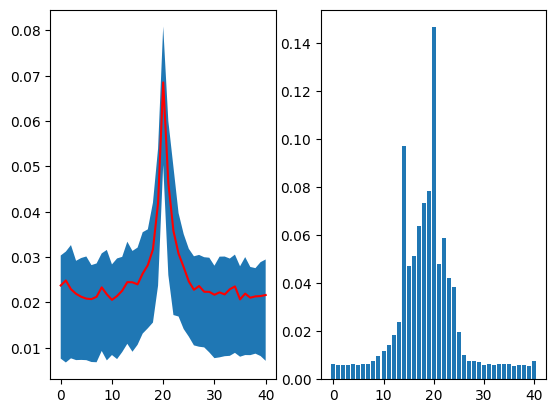

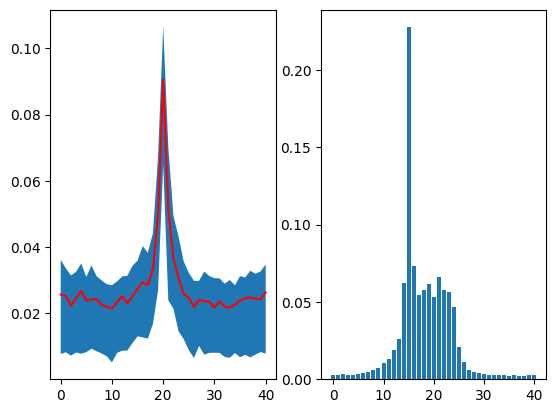

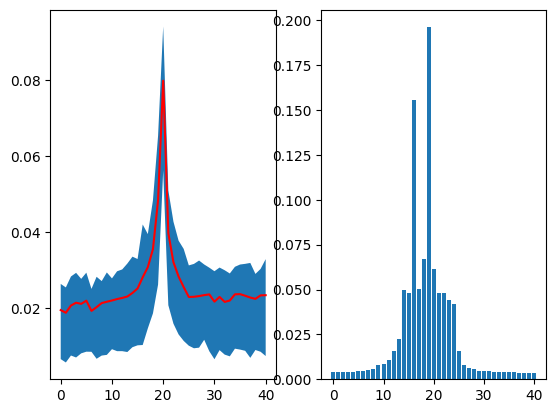

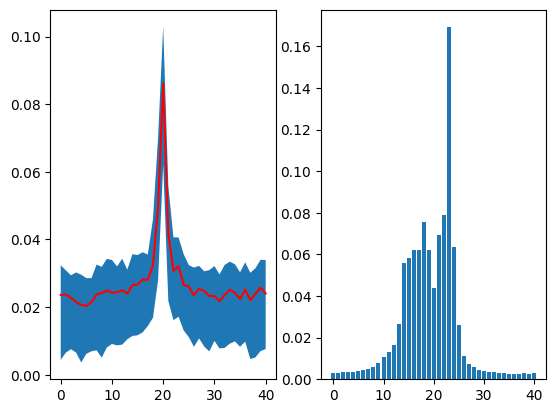

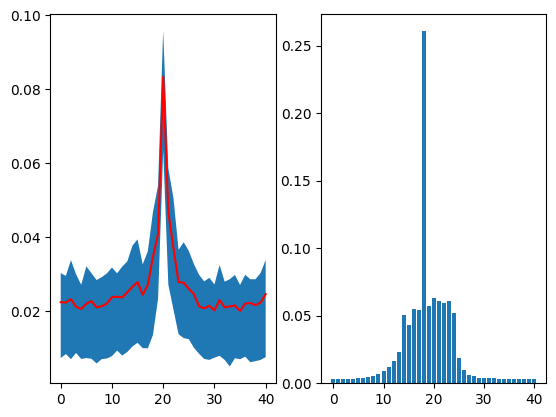

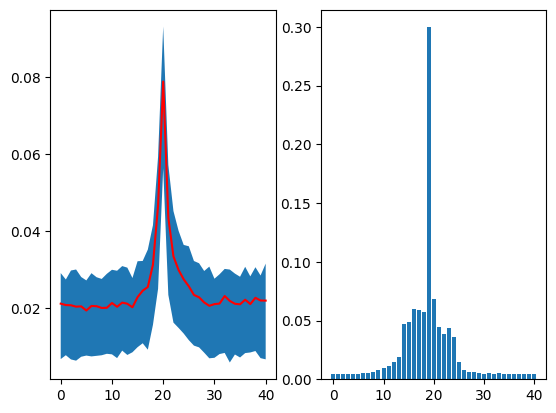

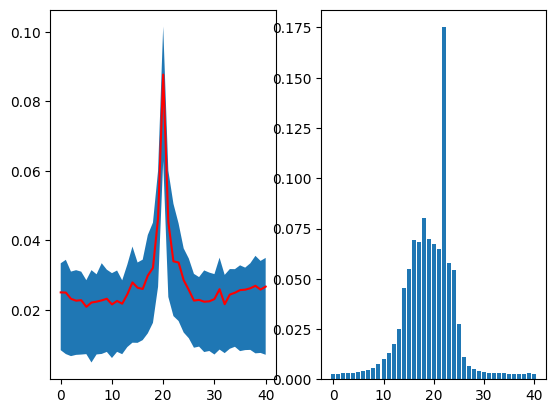

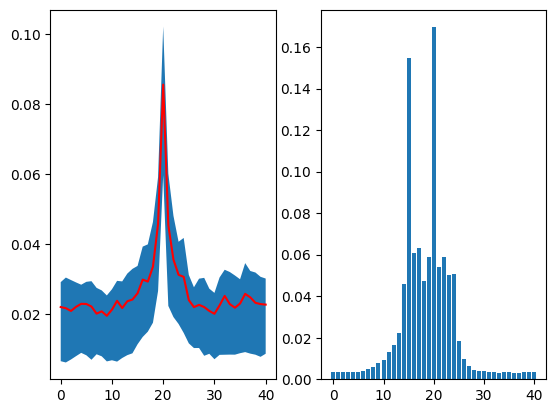

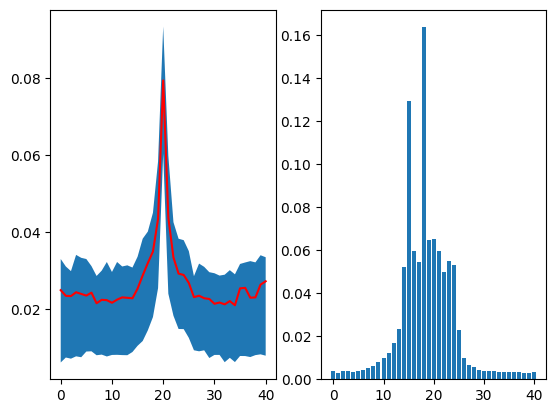

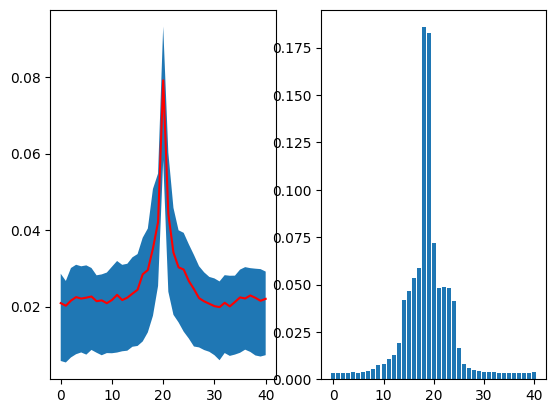

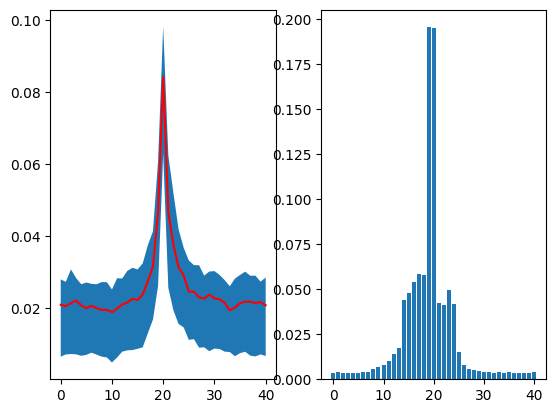

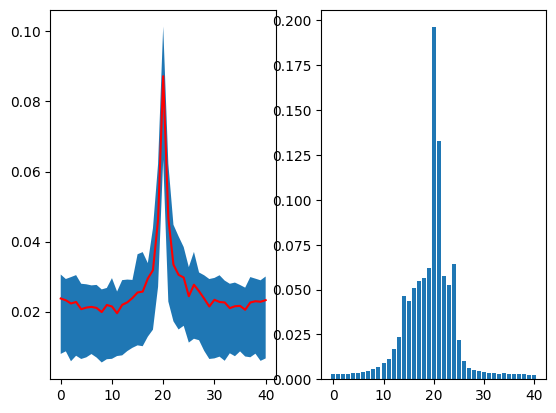

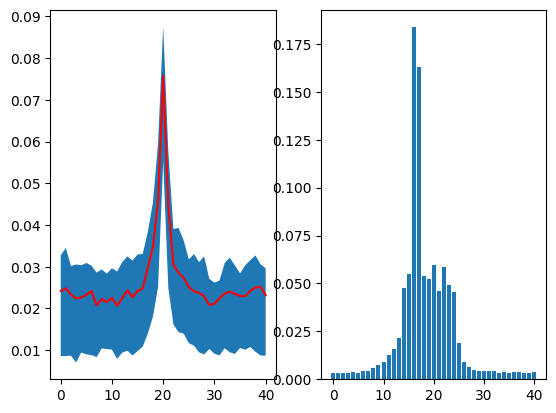

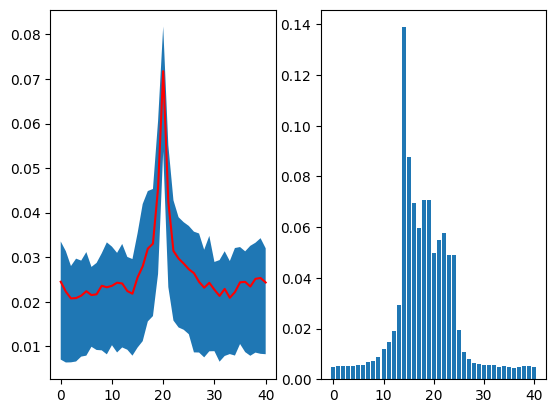

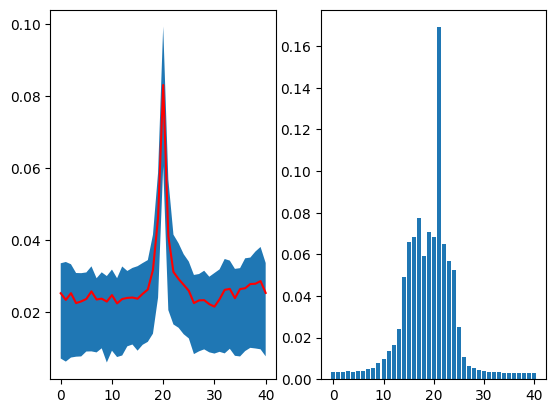

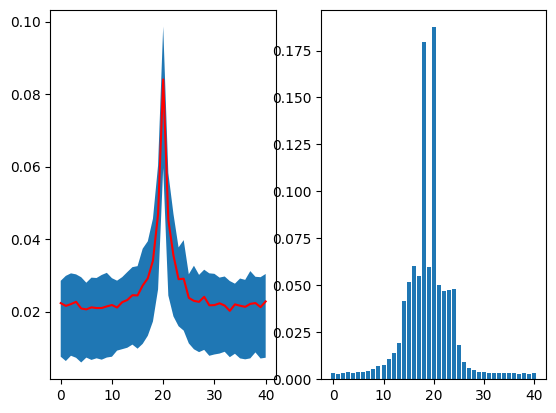

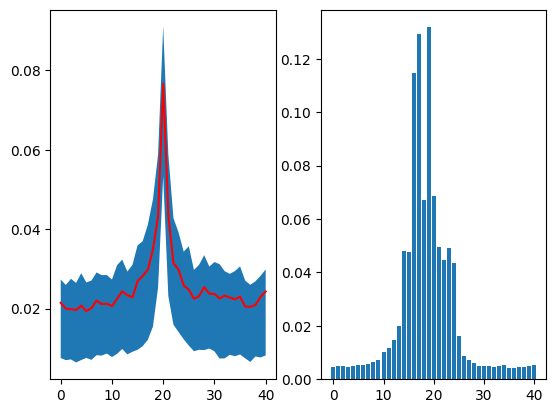

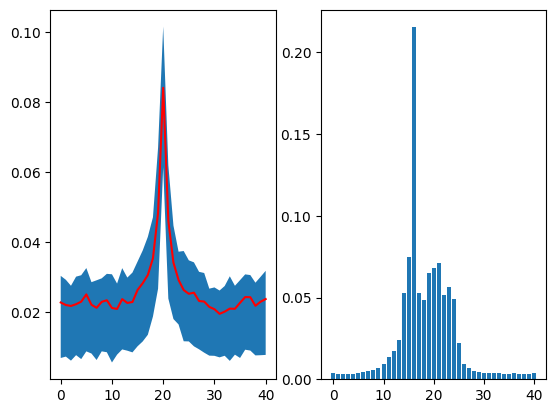

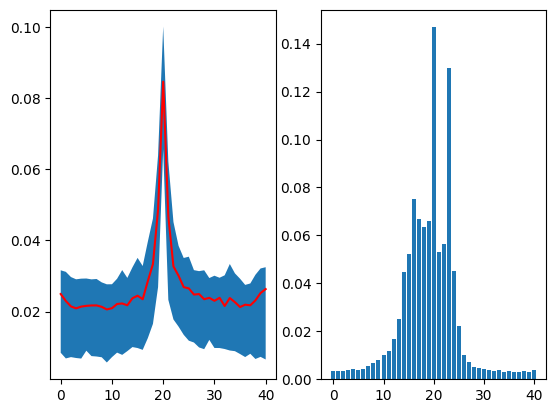

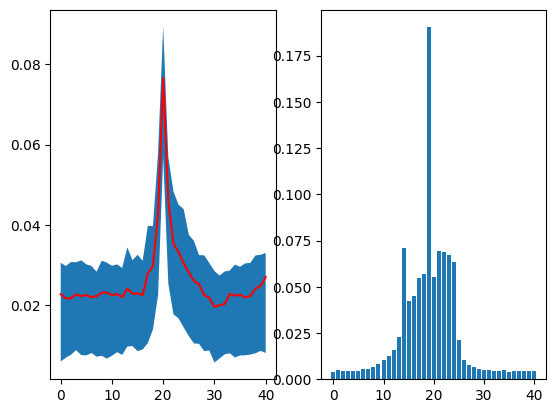

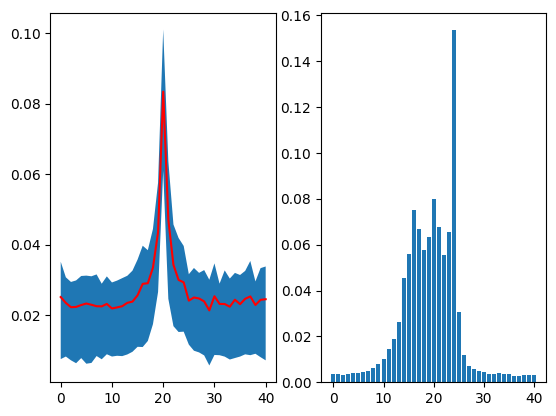

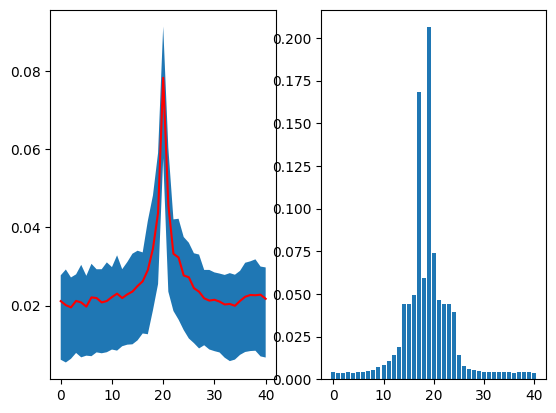

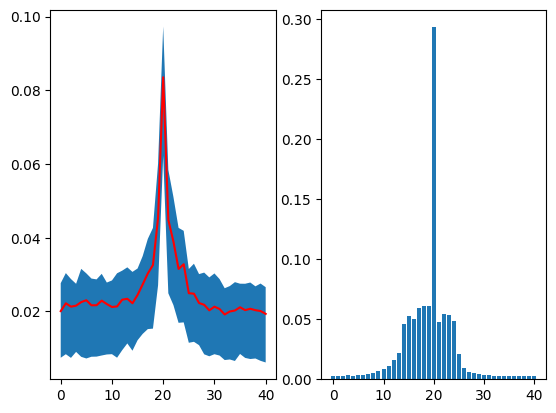

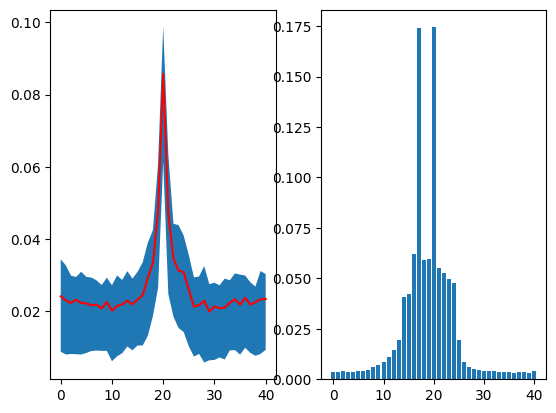

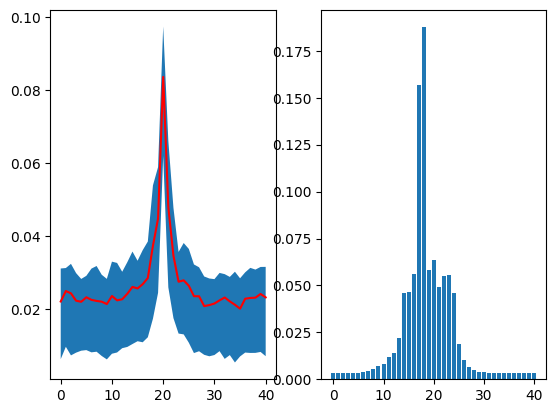

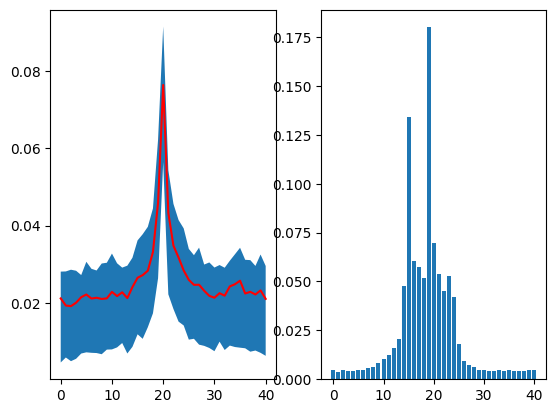

In [89]:
for i in np.unique(cluster_labels):
    _, (ax1, ax2) = plt.subplots(1,2)
    mean = np.nanmean(windows_counts[cluster_labels == i], 0)
    std = np.nanstd(windows_counts[cluster_labels == i], 0)
    ax1.plot(np.arange(windows_counts.shape[1]), np.nanmean(windows_counts[cluster_labels == i], 0), color='red')
    ax1.fill_between(np.arange(windows_counts.shape[1]), np.nanquantile(windows_counts[cluster_labels == i], .25, 0), np.nanquantile(windows_counts[cluster_labels == i], .75, 0))
    ax2.bar(np.arange(windows_attr.shape[1]), windows_attr[cluster_labels == i].mean(0))

In [40]:


X = windows
X = np.abs(X)
X = X / np.sum(X, 1)[:,None]
silhouette_rand_sub = np.arange(len(X))#np.random.choice(np.arange(len(X)), 50000, replace=False)
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in tqdm(range_n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X[silhouette_rand_sub], cluster_labels[silhouette_rand_sub])
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

  0%|          | 0/19 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.12312628500689804
For n_clusters = 3 The average silhouette_score is : 0.12686457702682663
For n_clusters = 4 The average silhouette_score is : 0.1311149920017395
For n_clusters = 5 The average silhouette_score is : 0.12987402287402763
For n_clusters = 6 The average silhouette_score is : 0.1318551075868953
For n_clusters = 7 The average silhouette_score is : 0.13262908709454194
For n_clusters = 8 The average silhouette_score is : 0.11397058599702632
For n_clusters = 9 The average silhouette_score is : 0.09612357108994773
For n_clusters = 10 The average silhouette_score is : 0.09644204073086599
For n_clusters = 11 The average silhouette_score is : 0.09162753987129554
For n_clusters = 12 The average silhouette_score is : 0.0936722459479404
For n_clusters = 13 The average silhouette_score is : 0.0953350549337771
For n_clusters = 14 The average silhouette_score is : 0.09329965329979066
For n_clusters = 15 The average silhouette_score i

KeyboardInterrupt: 